# **Text Classifier with the News Headlines Dataset**

This notebook demonstrates the implementation of a text classification model using a Transformer network for sentiment analysis. Its purpose is to distinguish between positive and negative movie reviews in the [IMDB Reviews dataset](http://ai.stanford.edu/~amaas/data/sentiment/). For this task, the pre-trained [RoBERTa (Robustly Optimized BERT Pretraining Approach)](https://huggingface.co/docs/transformers/en/model_doc/roberta) model from [Hugging Face 🤗](https://huggingface.co/) is fine-tuned to enhance its performance in sentiment analysis. Hugging Face is a platform focused on developing tools and AI models for natural language processing (NLP), known for its open-source library called Transformers, which provides an easy interface to work with advanced, pre-trained NLP models such as BERT, T5, GPT, and others.

**Key Points:**
- **Model Architecture:** The RoBERTa Large model from Hugging Face is used, which is based on [BERT](https://huggingface.co/docs/transformers/en/model_doc/bert) but achieves better results on GLUE, RACE, and SQuAD, datasets used to evaluate reasoning and text comprehension models. It is loaded using the generic class [TFAutoModel](https://huggingface.co/transformers/v3.0.2/model_doc/auto.html#tfautomodel), which allows creating an instance of a pre-trained model based on TensorFlow with just its name. Then, it is fine-tuned by adding a dropout layer and a dense classification layer with ``sigmoid`` activation, where 0 indicates a negative movie review and 1 indicates a positive movie review.

- **Tokenization:** RoBERTa uses ``input_ids``, which are the tokenized input sequence indices in the vocabulary, and ``attention_mask``, a mask to avoid paying attention to padding token indices. Hugging Face has already implemented a tokenizer for each of its models that returns everything necessary for the respective model inputs, so in this case, the generic tokenizer [AutoTokenizer](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoTokenizer) allows instantiating the model's tokenizer with just its name.

- **Using a TPU:** Due to the enormous size of the RoBERTa model, specifically ``roberta-large``, which has over 300 million parameters, using a TPU in Google Colab is required to significantly speed up training. Although only the parameters of the classification layer are fine-tuned, loading and processing pre-trained embeddings, along with intensive backpropagation calculations, require considerable computational resources. The TPU efficiently handles these tasks compared to GPUs or CPUs, optimizing performance and training time.

- **Comparison with the [Bidirectional LSTM Network Model](https://github.com/JersonGB22/TextClassification-TensorFlow/blob/main/models_lstm/SentimentAnalysis_LSTM_IMDB.ipynb):** In this notebook, the results obtained with the Transformer network using the RoBERTa model will be compared with the results obtained from the bidirectional LSTM network model.

### **Imports**

In [1]:
!pip install datasets -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 963.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 1.2 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
from datasets import load_dataset
from transformers import TFAutoModel, AutoTokenizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import re
from IPython.core.display import HTML
from google.colab import drive

In [ ]:
# TPU setup
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu)
  print("TPU initialized:")
  print("All devices: ", tf.config.list_logical_devices("TPU"))
except ValueError:
  print("TPU not found")

TPU initialized:
All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


### **Parameters**

In [3]:
epochs = 3
batch_size = 128
buffer_size = 1024
max_length = 512
AUTOTUNE = tf.data.AUTOTUNE
model_name = "roberta-large"

### **Load and Preprocess the Dataset**

In this case, when using a pre-trained Hugging Face model to load the IMDB Dataset, it is not advisable to do so with TensorFlow Datasets, as was done with the bidirectional LSTM model. This is because, to preprocess the training and test data and preprocess them in parallel with training in TensorFlow, only TensorFlow operations should be used. [Hugging Face tokenizers are not currently compatible with TensorFlow graphs](https://huggingface.co/docs/datasets/en/use_with_tensorflow).

It is true that preprocessing could be done with `tf.py_function`, but during training, this would cause errors since [the function body will not serialize in `GraphDef`](https://www.tensorflow.org/api_docs/python/tf/py_function). Additionally, it is not feasible to preprocess and use the Hugging Face tokenizer, then save the training and test datasets in a `TFRecord` file and use `tf.data.TFRecordDataset` to read them, as [they need to be stored in Google Cloud Storage (GCS) buckets to be used in a Colab TPU environment.](https://www.tensorflow.org/guide/tpu?hl=es-419)

Therefore, due to all the above, the Hugging Face Datasets library is used to load the IMDB data. They are then processed and tokenized, and converted to the `tf.data.Dataset.from_tensor_slices` format to retrain the model, as this format, being one of the simplest, does not need to be stored in GCS to be used on the Colab TPU.

In [5]:
dataset = load_dataset("imdb", split="train+test")
df = pd.DataFrame(dataset)
df

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0
...,...,...
49995,Just got around to seeing Monster Man yesterda...,1
49996,I got this as part of a competition prize. I w...,1
49997,I got Monster Man in a box set of three films ...,1
49998,"Five minutes in, i started to feel how naff th...",1


In [6]:
# The dataset is balanced
(df.label.value_counts()/df.shape[0]) * 100

0    50.0
1    50.0
Name: label, dtype: float64

In [8]:
# Import the AutoTokenizer
# 'use_fast=True': improves the tokenizer's performance when processing large volumes of text

tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
tokenizer

RobertaTokenizerFast(name_or_path='roberta-large', vocab_size=50265, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50264: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}

In [9]:
# Example of tokenization

sample_text = df.text[373] #One of the dataset's shortest reviews
print(sample_text, "\n")
encoding = tokenizer(
    sample_text,
    padding="max_length",
    truncation=True,
    max_length=25,
    return_token_type_ids=False,
    return_tensors="tf" #Returns the results in TensorFlow tensor format
)

print(encoding["input_ids"].numpy()[0], "\n")
print(tokenizer.convert_ids_to_tokens(encoding["input_ids"][0]))
print(tokenizer.decode(encoding["input_ids"][0]), "\n")

print(encoding["attention_mask"].numpy()[0], "\n")
print(df.label[373])

You'd better choose Paul Verhoeven's even if you have watched it. 

[    0  1185  1017   357  2807  1206  3060 23712  2987    18   190   114
    47    33  3996    24     4     2     1     1     1     1     1     1
     1] 

['<s>', 'You', "'d", 'Ġbetter', 'Ġchoose', 'ĠPaul', 'ĠVer', 'hoe', 'ven', "'s", 'Ġeven', 'Ġif', 'Ġyou', 'Ġhave', 'Ġwatched', 'Ġit', '.', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
<s>You'd better choose Paul Verhoeven's even if you have watched it.</s><pad><pad><pad><pad><pad><pad><pad> 

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0] 

0


Unlike BERT, RoBERTa uses a byte-level BPE (Byte Pair Encoding) as a tokenizer, similar to GPT-2.

In [10]:
# Function to convert texts to lowercase, remove HTML tags, and tokenize the texts

def preprocessing(texts):
  if type(texts) == list:
    texts = list(map(lambda x: re.sub(r"(<br />)+", " ", x.lower()), texts))
  else:
    texts = re.sub(r"(<br />)+", " ", texts.lower())

  encoding = tokenizer(
      texts,
      padding="max_length",
      truncation=True,
      max_length=max_length,
      return_tensors="tf"
  )

  return encoding["input_ids"], encoding["attention_mask"]

In [11]:
# Splitting the dataframe into training and testing sets

df_train, df_test = train_test_split(df, test_size=0.2, random_state=123, stratify=df.label)

train_dataset = tf.data.Dataset.from_tensor_slices(
    (preprocessing(df_train.text.to_list()), df_train.label.values)
)
test_dataset = tf.data.Dataset.from_tensor_slices(
    (preprocessing(df_test.text.to_list()), df_test.label.values)
)

train_dataset = train_dataset.shuffle(buffer_size, seed=123).batch(batch_size).prefetch(AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(AUTOTUNE)

In [ ]:
# View a processed batch

for (ids, masks), labels in train_dataset.take(1):
  print(ids, "\n")
  print(masks, "\n")
  print(labels)

tf.Tensor(
[[    0   405    16 ...     1     1     1]
 [    0  9226    16 ...     1     1     1]
 [    0  1610  2449 ...     1     1     1]
 ...
 [    0   627    65 ...     1     1     1]
 [    0 30115 12606 ...    77  3668     2]
 [    0   415     5 ...     1     1     1]], shape=(128, 512), dtype=int32) 

tf.Tensor(
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 0 0 0]], shape=(128, 512), dtype=int32) 

tf.Tensor(
[0 0 0 1 0 1 1 0 0 1 1 0 1 1 0 1 0 0 0 0 1 0 1 0 0 0 0 1 1 1 1 0 1 0 1 0 0
 1 1 0 1 1 0 1 0 0 0 0 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 0 0 0 1 0 1 0 0 1
 1 1 0 1 0 1 1 1 0 0 1 0 1 0 1 1 0 0 0 0 0 0 1 0 0 1 1 0 0 1 1 0 1 0 0 1 0
 1 0 0 0 0 0 0 1 1 0 0 1 1 1 0 1 1], shape=(128,), dtype=int64)


In [12]:
# Thanks to the 'stratify' argument, the distribution is preserved

print(len(df_train), len(df_test), "\n")
print((df_train.label.value_counts()/df_train.shape[0]) * 100, "\n")
print((df_test.label.value_counts()/df_test.shape[0]) * 100)

40000 10000 

1    50.0
0    50.0
Name: label, dtype: float64 

0    50.0
1    50.0
Name: label, dtype: float64


### **Build the Model**

In [13]:
def create_model():
  # Import the AutoModel
  model_base = TFAutoModel.from_pretrained(model_name)

  input_ids = tf.keras.Input((max_length, ), dtype=tf.int32)
  attention_mask = tf.keras.Input((max_length, ), dtype=tf.int32)

  x = model_base(input_ids=input_ids, attention_mask=attention_mask).pooler_output
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Dense(1, activation="sigmoid")(x)

  model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=x)

  return model

In [ ]:
tf.keras.backend.clear_session() #Clearing Keras memory
tf.random.set_seed(123) #For reproducibility

# Creation and compilation of the model within the distribution strategy
with strategy.scope():
  model = create_model()

  model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=2e-5, weight_decay=0.01),
                loss="binary_crossentropy",
                metrics=["accuracy"],
                steps_per_execution=200)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.bias', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

The message indicates that it is recommended to train the model on a downstream task before using it for predictions and inferences. This is correct, as the model has not been fine-tuned yet.

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  355359744  ['input_1[0][0]',                
 el)                            thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

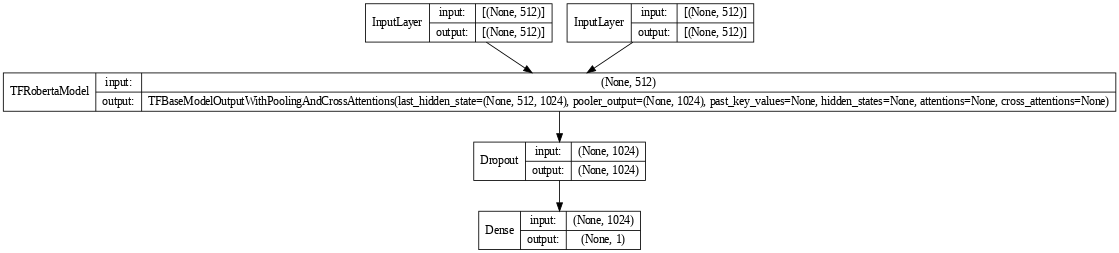

In [ ]:
# Visualizing the architecture of the model
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False, dpi=60)

### **Train the Model**

In [ ]:
tf.random.set_seed(123)
history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset)

Epoch 1/3
313/313 [==============================] - 674s 2s/step - loss: 0.2002 - accuracy: 0.9152 - val_loss: 0.1095 - val_accuracy: 0.9618
Epoch 2/3
313/313 [==============================] - 470s 2s/step - loss: 0.0939 - accuracy: 0.9690 - val_loss: 0.1234 - val_accuracy: 0.9616
Epoch 3/3
313/313 [==============================] - 470s 2s/step - loss: 0.0644 - accuracy: 0.9794 - val_loss: 0.1401 - val_accuracy: 0.9627


**Save model**

Due to the large size of the model, only its weights are saved.

In [ ]:
drive.mount("/content/drive/")

trained_model_path = "/content/drive/MyDrive/models/SentimentAnalysis_RoBERTa_IMDB.h5"
model.save_weights(trained_model_path)

### **Dataset Evaluation**

In [ ]:
print(model.evaluate(train_dataset, verbose=0))
print(model.evaluate(test_dataset, verbose=0))

[0.030379535630345345, 0.9916499853134155]
[0.14013829827308655, 0.9627000093460083]


The training set achieves an accuracy of 99.2% in just 3 epochs, while the test set accuracy is 96.3%. This demonstrates that the Transformer model is superior to the bidirectional LSTM model, which only achieved 90.5% accuracy on the test set. There is a notable reduction in overfitting; however, the model still exhibits some overfitting. This could be mitigated by increasing the size of the training set, as we are already using a robust model for NLP tasks with appropriate hyperparameter selection.

**Confusion Matrix**

In [ ]:
labels_test = df_test.label.values
labels_test_pred = model.predict(test_dataset, verbose=0).squeeze()
labels_test_pred = (labels_test_pred>=0.5).astype(np.int32)

In [ ]:
# Consolidating the accuracy of the testing set
np.mean(labels_test == labels_test_pred)

0.9627

Total negatives:  5000 ; Total positives:  5000


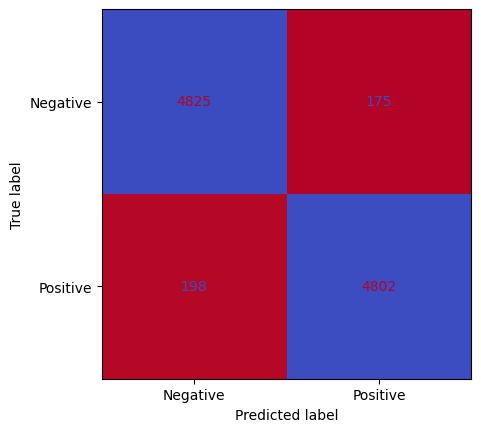

In [ ]:
cm = confusion_matrix(labels_test, labels_test_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=["Negative", "Positive"])
cmd.plot(colorbar=False, cmap="coolwarm_r");
print("Total negatives: ", np.bincount(labels_test)[0], "; Total positives: ", np.bincount(labels_test)[1])

In [ ]:
(175/5000)*100, (198/5000)*100

(3.5000000000000004, 3.9600000000000004)

It is observed that the model faces a slightly higher difficulty in correctly classifying positive movie reviews, as reflected in a higher percentage of false negatives (3.96%) compared to false positives (3.5%). However, in comparison to the LSTM network, it has significantly improved. This is because the model is quite capable of detecting the complex relationships necessary to classify movie reviews correctly, very closely resembling how humans would do it, thanks to the pretraining of RoBERTa.

### **Predictions with the trained model**

**``Example of how to save and load the complete model``**

```
trained_model_path = "/content/drive/MyDrive/models/SentimentAnalysis_RoBERTa_IMDB.keras"
model.save(trained_model_path)

model_base = TFAutoModel.from_pretrained(model_name)
model = tf.keras.models.load_model(trained_model_path,
                                  custom_objects={"TFRobertaModel": model_base})

model.summary()
```

In [15]:
# Load the weights of the trained model
tf.keras.backend.clear_session()

model = create_model()
model.load_weights(trained_model_path)

model.summary()

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.weight', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  355359744  ['input_1[0][0]',                
 el)                            thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

In [99]:
def predict_review(texts, labels, random=True):
  label_names = ["Negative Review", "Positive Review"]
  label_colors = ["red", "green"]

  indice = np.random.choice(len(texts)) if random else 0
  text = texts[indice]
  input_ids, attention_mask = preprocessing(text)

  label_pred = model.predict([input_ids, attention_mask], verbose=0).squeeze()
  label_pred = (label_pred>=0.5).astype(np.int32)

  html_content = f"""
    <b>Review:</b><br><br>
    {text}<br><br>
    <b>True Label: <span style="color: {label_colors[labels[indice]]}">{label_names[labels[indice]]}</span></b><br><br>
    <b>Predicted Label: <span style="color: {label_colors[label_pred]}">{label_names[label_pred]}</span></b>
    """
  display(HTML(html_content))

#### **Test Dataset**

In [18]:
texts, labels = df_test.text.to_list(), df_test.label.to_list()

In [100]:
predict_review(texts, labels, random=False)

In [ ]:
predict_review(texts, labels)

In [108]:
# Long Review
predict_review(texts, labels)

In [113]:
# Long Review
predict_review(texts, labels)

#### **Other Reviews**

In [114]:
text = ["""
'The Sunrise of Tomorrow' is a cinematic masterpiece that truly captures the essence of human resilience.
The performances are stellar, particularly the lead actor who delivers a heart-wrenching performance that leaves you on the edge of your seat.
The cinematography is breathtaking, with each frame painting a beautiful picture that stays with you long after the movie ends.
The plot is well-crafted, with unexpected twists that keep you engaged throughout.
This movie is a must-watch for anyone seeking a profound cinematic experience.
"""]

label = [1]

predict_review(text, label)

In [115]:
text = ["""
I had high hopes for "The Sunrise of Tomorrow", but unfortunately, it fell short of expectations.
The plot was predictable and lacked depth, making it difficult to connect with the characters on any meaningful level.
The performances felt forced and lacked the emotional depth necessary for such a storyline.
The cinematography, while visually appealing, couldn't make up for the lackluster script.
Overall, the movie felt like a missed opportunity to explore an interesting concept.
"""]
label = [0]

predict_review(text, label)

In [116]:
# Complex positive review, incorporating seemingly negative words.

text = ["""
I'm absolutely disgusted that this movie isn't being sold. Everyone who loves this film should email Disney to increase the demand for it.
Eventually, they'd have to sell it, and then I'd buy copies for everybody I know. Everyone and everything in this movie did a good job,
and I can't figure out why Disney hasn't put it on DVD or even on VHS in rental stores.
I haven't seen any copies. This is a fantastic movie that deserves to be seen by all the kids in the new generation.
They're missing out, and I think they deserve the chance to experience it.
"""]
label = [1]

predict_review(text, label)

In [117]:
# Complex negative review, incorporating seemingly positive words.

text = ["""
The film "Sunset Dreams" is an extraordinary example of how cinema can transcend the mundane and reach new heights of mediocrity.
The director's vision is remarkably consistent, maintaining a steady pace that ensures the audience is lulled into a state of unending tedium.
The performances are nothing short of unforgettable; they are bound to linger in the viewer's mind for all the wrong reasons.
Each actor brings a unique blend of wooden expressions and uninspired dialogue delivery,
which together create an experience that is truly singular in its capacity to disappoint.<br /><br />
The cinematography, while technically competent, showcases a remarkable talent for capturing the most uninteresting angles,
ensuring that every scene is as visually unappealing as possible. The soundtrack is another standout feature,
with its repetitive and grating melodies that add an extra layer of irritation to the viewing experience.
"""]

label = [0]

predict_review(text, label)

The model demonstrates accurate predictions not only within the test set but also with other movie reviews that do not belong to either the training or test set. Furthermore, it shows significant robustness in correctly classifying challenging reviews: those with a negative appearance that are actually positive, or vice versa, thanks to its multiple layers of attention that capture complex relationships within sentences.